In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.functions import emission_profile_function
from metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from climate_models.co2_ipcc_climate_model import co2_ipcc_climate_model
from climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model
from scipy.stats import qmc

## Parameters

In [2]:
start_year = 1765
t0 = 2020
time_horizon = 100

sensitivity_rf_co2 = 9.2e-16 # Not used with FaIR
ratio_erf_rf_co2 = 1
efficacy_erf_co2 = 1
unit_value_co2 = 1*10**10

In [3]:
species = "Aviation NOx - CH4 decrease and induced"

In [4]:
if species == "Aviation contrails":
    unit_value = 1*10**10
    variables = {
        "time_horizon_log": (np.log(10), np.log(200)),
    }

elif species == "Aviation NOx - ST O3 increase":
    unit_value = 1*10**10
    variables = {
        "time_horizon_log": (np.log(10), np.log(200)),
    }

elif species == "Aviation NOx - CH4 decrease and induced":
    unit_value = 1*10**10
    variables = {
        "time_horizon_log": (np.log(10), np.log(200))
    }
    
n_samples = 100 
dim = len(variables)

sampler = qmc.LatinHypercube(d=dim)
sample = sampler.random(n=n_samples)

l_bounds = [v[0] for v in variables.values()]
u_bounds = [v[1] for v in variables.values()]
scaled_sample = qmc.scale(sample, l_bounds, u_bounds)

df = pd.DataFrame(scaled_sample, columns=variables.keys())

In [5]:
species_settings_co2 = {"sensitivity_rf": sensitivity_rf_co2, "ratio_erf_rf": ratio_erf_rf_co2, "efficacy_erf": efficacy_erf_co2}

ratr_list = np.zeros(n_samples)

for i in range(0, n_samples):
    
    time_horizon = int(np.exp(df["time_horizon_log"].loc[i]))

    if species == "Aviation contrails":
        sensitivity_rf = 2.23e-12
        ratio_erf_rf = 0.42
        efficacy_erf = 1
    elif species == "Aviation NOx - ST O3 increase":
        sensitivity_rf = 25.1e-12 * (14/46)
        ratio_erf_rf = 1.37
        efficacy_erf = 1
    elif species == "Aviation NOx - CH4 decrease and induced":
        sensitivity_rf = -0.83e-9
        ratio_erf_rf = 1.18
        efficacy_erf = 1
    
    end_year = t0 + time_horizon
    background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')
    model_settings_co2 = {"background_species_quantities": background_species_quantities}
    model_settings = {"background_species_quantities": background_species_quantities}
    
    emission_profile_co2 = emission_profile_function(start_year,t0,time_horizon, 'pulse', unit_value_co2)
    emission_profile = emission_profile_function(start_year,t0,time_horizon, 'pulse', unit_value)
    radiative_forcing_co2, effective_radiative_forcing_co2, temperature_co2 = species_fair_climate_model(start_year, end_year, "Aviation CO2", emission_profile_co2, species_settings_co2, model_settings_co2)
    radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, temperature_co2_unit = radiative_forcing_co2/unit_value_co2, effective_radiative_forcing_co2/unit_value_co2, temperature_co2/unit_value_co2
    agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2 = absolute_metrics(radiative_forcing_co2_unit, effective_radiative_forcing_co2_unit, efficacy_erf_co2, temperature_co2_unit, time_horizon)
    
    species_settings = {"sensitivity_rf": sensitivity_rf, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
    radiative_forcing, effective_radiative_forcing, temperature = species_fair_climate_model(start_year, end_year, species, emission_profile, species_settings, model_settings)
    radiative_forcing_unit, effective_radiative_forcing_unit, temperature_unit = radiative_forcing/unit_value, effective_radiative_forcing/unit_value, temperature/unit_value
    agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr = absolute_metrics(radiative_forcing_unit, effective_radiative_forcing_unit, efficacy_erf, temperature_unit, time_horizon)
    
    gwp_rf, gwp_erf, egwp_rf, egwp_erf, gtp, igtp, ratr = relative_metrics(agwp_rf_co2, agwp_erf_co2, aegwp_rf_co2, aegwp_erf_co2, agtp_co2, iagtp_co2, atr_co2, agwp_rf, agwp_erf, aegwp_rf, aegwp_erf, agtp, iagtp, atr)
    ratr_list[i] = ratr

In [6]:
if species == "Aviation NOx - CH4 decrease and induced":
    df['ratr_log'] = np.log(-ratr_list)
else:
    df['ratr_log'] = np.log(ratr_list)
print(df)

    time_horizon_log  ratr_log
0           3.768339  5.475237
1           3.419289  5.715041
2           5.173273  4.373377
3           3.926084  5.365423
4           3.188597  5.842761
..               ...       ...
95          4.380088  5.014313
96          3.157860  5.865065
97          2.498579  6.125596
98          4.076209  5.253845
99          4.733896  4.732176

[100 rows x 2 columns]


In [7]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Variables (logarithm)
if species == "Aviation NOx - CH4 decrease and induced":
    X = df.copy()
    X["time_horizon_log_2"] = X["time_horizon_log"]**2
    X = X[["time_horizon_log", "time_horizon_log_2"]]
    print(X)
    y = df[["ratr_log"]]
else:
    X = df[["time_horizon_log"]]
    y = df[["ratr_log"]]

# Linear regression (logarithm)
model = LinearRegression()
model.fit(X, y)

coeffs = model.coef_
intercept = model.intercept_
features = X.columns
#equation = f"ratr_log = {intercept:.4f}"
#for i in range(len(features)):
#    equation += f" + ({coeffs[i]:.4f}) × {features[i]}"
#print("Équation de la régression :")
#print(equation)

# Assessment
y_pred = model.predict(X)
r2 = r2_score(np.exp(y), np.exp(y_pred))
rmse = mean_squared_error(y, y_pred)

print(f"\nR² : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")

print(coeffs, intercept)

    time_horizon_log  time_horizon_log_2
0           3.768339           14.200381
1           3.419289           11.691540
2           5.173273           26.762752
3           3.926084           15.414137
4           3.188597           10.167151
..               ...                 ...
95          4.380088           19.185171
96          3.157860            9.972080
97          2.498579            6.242895
98          4.076209           16.615478
99          4.733896           22.409767

[100 rows x 2 columns]

R² : 0.9981
RMSE : 0.0003
[[ 0.104509   -0.10141138]] [6.52257467]


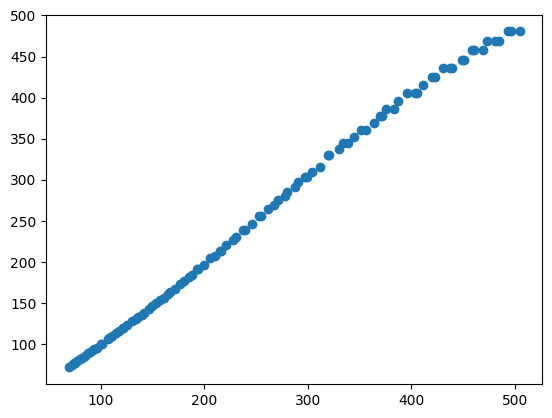

In [8]:
plt.scatter(np.exp(y_pred), np.exp(y))

In [9]:
np.min(((np.exp(y)-np.exp(y_pred))/np.exp(y_pred))*100)


np.float64(-4.741536554818508)

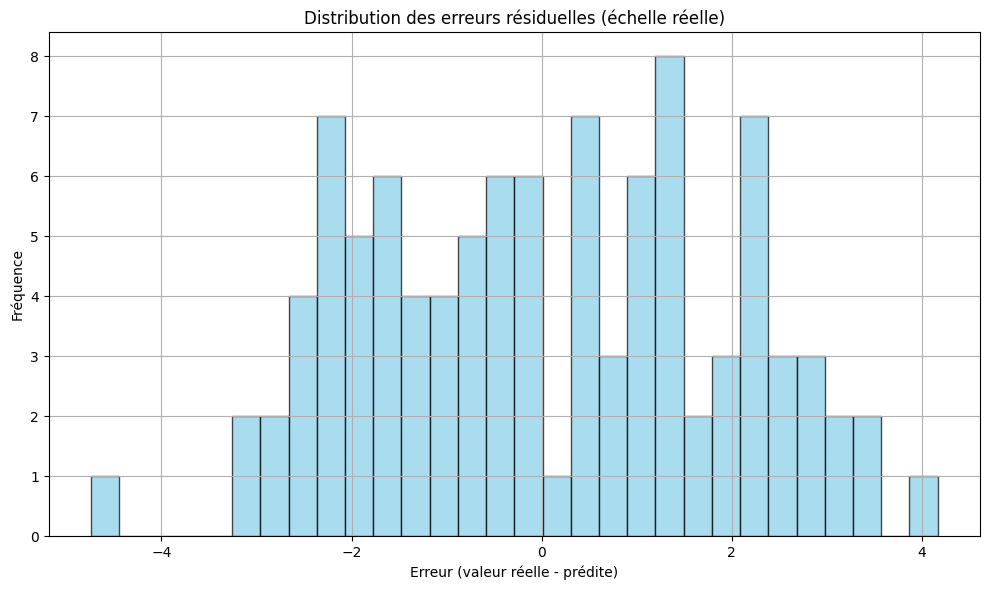

In [10]:
# Calcul des erreurs résiduelles (en log et en échelle réelle)
residuals_log = y - y_pred
residuals_real = (np.exp(y) - np.exp(y_pred))/np.exp(y_pred)*100

# Affichage de la distribution des résidus en échelle réelle
plt.figure(figsize=(10, 6))
plt.hist(residuals_real, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution des erreurs résiduelles (échelle réelle)")
plt.xlabel("Erreur (valeur réelle - prédite)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
np.exp(34.0726)

np.float64(627396604717939.9)

In [12]:
def ratr_contrails(time_horizon, sensitivity_rf_contrails, ratio_erf_rf_contrails, efficacy_erf_contrails):
    ratr = 6.38 * sensitivity_rf_contrails/2.23e-12 * ratio_erf_rf_contrails/0.42 * efficacy_erf_contrails / time_horizon**0.8457
    return ratr

time_horizon = 100
sensitivity_rf_contrails = 2.23e-12
ratio_erf_rf_contrails = 0.42
efficacy_erf_contrails = 1

val = ratr_contrails(time_horizon, sensitivity_rf_contrails, ratio_erf_rf_contrails, efficacy_erf_contrails)
print(val)

0.12984363905620883
